# Introduction to signal transformation

**Signal transformation** techniques can help to extract meaningful information, reduce noise, or prepare data for further analysis. This notebook covers three examples:
* Fast Fourier Transform (FFT)
* Continuous Wavelet Transform (CWT)
* Discrete Wavelet Transform (DWT)

## Contents:
* [Notebook set-up](#setup)
* [Definitions](#definitions)
    * [Wave](#wave)
    * [Wavelet](#wavelet)
    * [Signal](#signal)
    * [Signal processing](#signal_processing)
* [Fast Fourier Transform (FFT)](#fft)
* [The Wavelet Transform](#wavelet_transform)
* [Discrete Wavelet Transformation (DWT)](#dwt)
* [Continuous Wavelet Transformation (CWT)](#cwt)

## Notebook set-up <a class="anchor" id="setup"></a>

In [1]:
# Import packages
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy import signal
from scipy.fftpack import fft, ifft

In [2]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Clip to last 90 minutes
    fhr = fhr.tail(90*60)

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    return(fhr)

In [3]:
# Import example of a FHR and UCR to be used in notebook
ctg = pd.read_csv('data_csv/1001.csv')
fhr = clean_fhr(ctg['FHR'])
uc = ctg['UC']

## Definitions <a class="anchor" id="definitions"></a>

### Wave <a class="anchor" id="wave"></a>

A wave is an osciallation about a rest position. You can notice it has a rest point (if drew horizontal line through middle), peaks (high point above rest position) and troughs (low point below rest poition). Its wavelength is the distance covered by one cycle of the wave (peak to peak or trough to trough).

Two further properties of a wave:
* **Amplitude** = distance between the rest position and the peak/trough.
* **Frequency** = number of waves passing a point per second, with frequency unit of hertz (Hz).

Below is an example of a type of wave called a **sine wave**. Sine are basic, continuous repetitative waves representing a single frequency, with no harmonics (distortions).

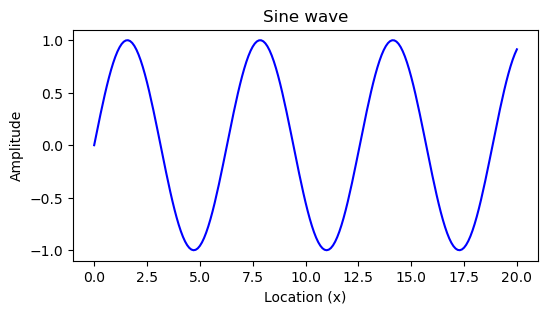

In [4]:
# Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.01-The-Basics-of-waves.html

x = np.linspace(0, 20, 201)
y = np.sin(x)

plt.figure(figsize = (6, 3))
plt.plot(x, y, 'b')
plt.ylabel('Amplitude')
plt.xlabel('Location (x)')
plt.title('Sine wave')
plt.show()

### Wavelet <a class="anchor" id="wavelet"></a>

The word wavelet comes from the french *ondelette* which means "little wave". For a function to be a wavelet it must:
* **Have a mean of zero** - This is known as the admissibility condition, or as having no zero-frequency component. Essentially, the average value of your function is 0
* **Be rapidly decaying** - This means it is localised in time and does not extend to infinity (unlike the sine wave above). This is also known as having finite energy.

There are many types of wavelets and they are grouped into families. Below is an example of a Morlet wavelet.

When referring to wavelets, we often talk about **scales** rather than **frequencies**. This is because the term "frequency" doesn't technically make sense for wavelets as they are **rapidly decaying**, and so we might instead talk about **pseudo-frequency**. **Scale and frequency are inversely proportional**.

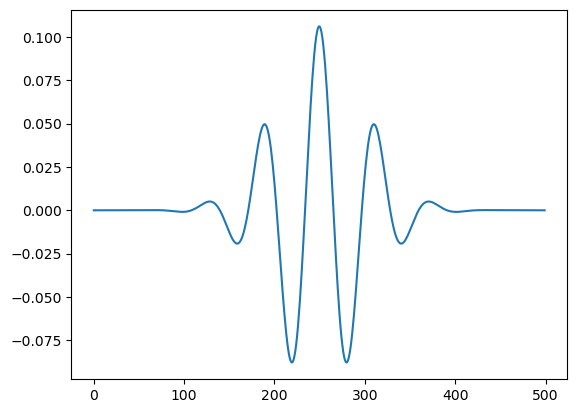

In [5]:
# Define wavelet parameters
M = 500 # Length of wavelet
s = 50 # Width parameter of wavelet
w = 5 # Omega0

# Create and plot wavelet
wavelet = signal.morlet2(M, s, w)
plt.plot(np.real(wavelet))
plt.show()

### Signal <a class="anchor" id="signal"></a>

A signal is a function conveying information about a phenomenon. Any quantity that varies over space or time can be used as a signal. Examples of signals: audio, video, speech, image, sonar, and radar. In this project, the signals we are focussing on are the **fetal heartbeat (FHR)** and **uterine contractions (UC)** recorded during labour using **cardiotocography (CTG)**.

Properties of signals:
* **Amplitude**
* **Frequency**
* **Wavelength**
* **Phase**

These are not always relevant - for example, some signals will not have a well-defined frequency (e.g. random signals), with the concept of frequency being most relevant for signals that exhibit some form of **periodicity** (repetition after a fixed interval) or **oscillation** (variation about a central point). However, in any case, frequencies relevant for the signal can be identified (such as through using Fourier transformation), even if it doesn't feel as intuitive as when you look at a sine wave and see frequency.

You can have a **continuous signal** (where it is continuous - at every step there is a value, no matter how far you zoom in) or a **discrete-time signal** (which is only defined at specific steps. A continuous signal is digitised by sampling it at a specific sample rate. Hence, the **sampling rate/frequency** is the number of samples per second (or other unit) taken from a continuous signal to make a discrete or digital signal - e.g. measured in cycles per second or Hertz (Hz). In this project, **FHR and UC are continuous signals that were sampled at 4Hz**. The CTG recordings were using to calculate FHR and UC in bpm, and the dataset we have provides the **results (e.g. FHR in bpm) for each second of labour**.

### Signal processing <a class="anchor" id="signal_processing"></a>

Signal processing can include dealing with irregular/missing data, noise and outliers, among other things. There are many signal processing techniques - with one example being transforms like FFT, DWT and CWT.

## Signal Transformation Technique #1: The Fast Fourier Transform (FFT) <a class="anchor" id="fft"></a>

FFT is an efficient algorithm for calculating the Discrete Fourier Transform and is the standard way to calculate a fourier transform. FFT can be used to decompose a signal into its **frequency** components. It breaks down a signal into a series of wine waves (each with unique magnitudes, frequencies and phases). Results are displayed in a figure called a **power spectrum**, where the amplitude of the sinusoidal terms are plot against their frequency.

See the example below - we added together a 1Hz, 4Hz and 7Hz sine wave to create a single signal. Applying FFT allows us to identify those frequencies as being present, as in the power spectrum below.

This is **not the best technique** for this project, we are interested in not just what frequencies occurred but when they were present. FFT is more suited to signals with a **stationary frequency spectrum** (i.e. frequencies present are not time-dependent and could be present equally anywhere in the signal), since it represents signals using sine waves which are not localised in time or space.

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


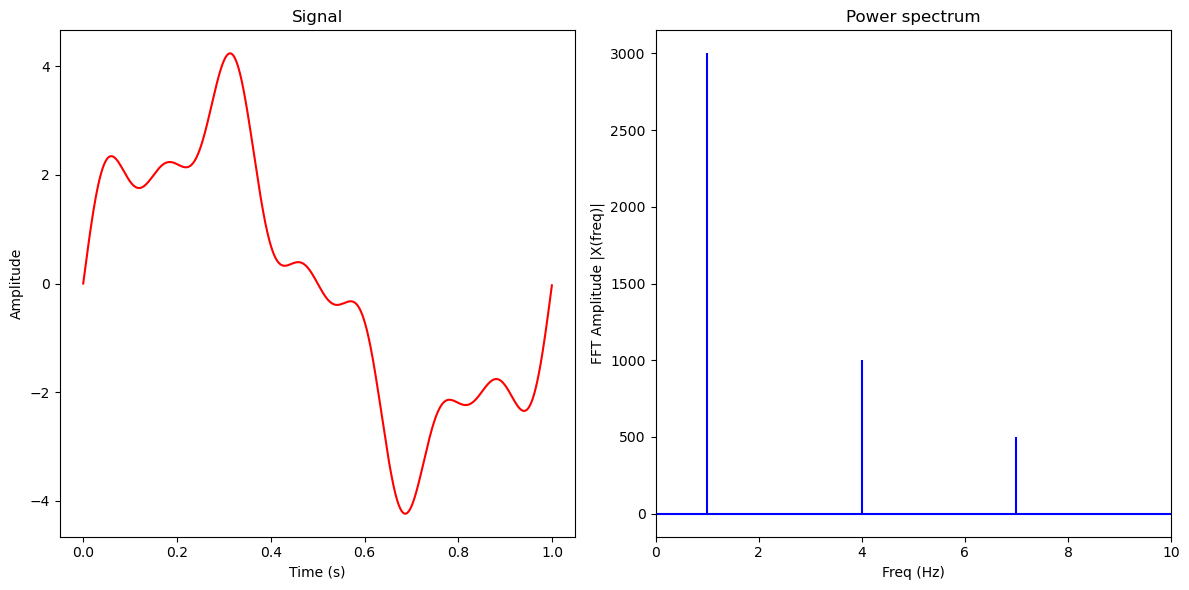

In [6]:
# Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html

# Create an example signal containing 3 frequencies - 1, 4 and 7
sampling_rate = 2000
sampling_interval = 1/sampling_rate
t = np.arange(0, 1, sampling_interval)
freq = 1
x = 3*np.sin(2*np.pi*freq*t)
freq = 4
x += np.sin(2*np.pi*freq*t)
freq = 7
x += 0.5* np.sin(2*np.pi*freq*t)

# Apply the Fast Fourier Transform
X = fft(x)

# Plot the transform
plt.figure(figsize = (12, 6))
plt.subplot(122)
N = len(X)
n = np.arange(N)
T = N/sampling_rate
freq = n/T 
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)
plt.title('Power spectrum')

# Plot the signal
plt.subplot(121)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal')

plt.tight_layout()
plt.show()

## The Wavelet Transform <a class="anchor" id="wavelet_transform"></a>

The wavelet transform decomposes a signal by **frequency** and **time**. This is better than FFT for signals with a **dynamic frequency spectrum** (i.e. frequency spectrum changes over time or changes abruptly for short periods of time).

##### How does it work?

The general principle of the wavelet transform is to look at the signal on different scales. It uses a series of **wavelet functions which have different scales** (i.e. different frequencies - scale is just the inverse of frequency). There are many different wavelets to choose from. The chosen wavelet is referred to as the **mother wavelet** and the scaled wavelets are **daughter wavelets**.

The wavelets are localised in time, so we multiply the signal by the wavelet at different locations, **shifting** the wavelet along the signal. We repeat this with wavelets of different scales.
* **Lower frequency wavelets** capture slowly varying changes in a signal (i.e. lower frequencies in signal)
* **Higher frequency wavelets** capture abrupt change sin a signal (i.e. higher frequencies in signal)

##### The Uncertainty Principle

In signal transformation, we cannot know both frequency and time in perfect detail, which is an example of the uncertainty principle. FFT chooses to focus only on knowing the frequencies present. The wavelet transform makes a trade-off between frequency and time:
* At **lower frequencies**, the uncertainty boxes are wide (i.e. **time less certain**) - which makes sense, as low frequencies by their nature tend to **last longer** (so high time resolution less important)
* At **higher frequencies**, the uncertainty boxes are tall (i.e. **frequency less certain**) - which makes sense, as high frequencies tend to be **brief and localised in time** (so need a higher time resolution).

This can be visuliased using Heisenberg boxes, as in the image below.

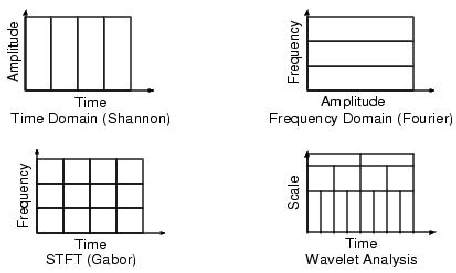

In [7]:
# Source: https://www.researchgate.net/figure/Time-Frequency-STFT-Wavelet-views-of-signal-analysis_fig2_259388604
Image(filename='images/heisenberg_boxes.png') 

This relationship also becomes apparent in **scaleograms**, as the results appear to be relatively blurry, being:
* More stretched in the x axis (time) at lower frequencies (or higher scales)
* More narrow on the x axis (time) at higher frequencies (or lower scales)

In the example below, the spectogram is produced from a signal that has mostly high frequency, three section of low frequency, which at their peaks have high frequencies.

##### How to interpret scaleogram?
* X axis is time
* Y axis is the wavelet scale (or here converted to frequency, which is just the inverse - higher scale = lower frequency)
* Colours represent amplitude (meaning we're preserving information about the shape of the signal, which we would glean from frequency and amplitude)

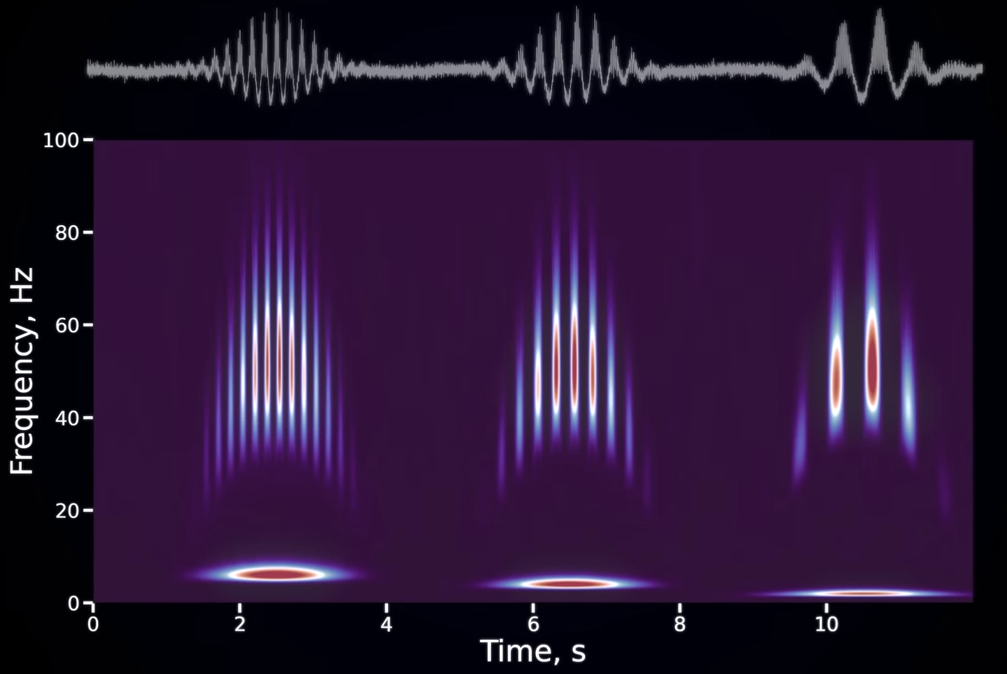

In [8]:
# Source: https://youtu.be/jnxqHcObNK4?si=io1Ae6FLeekiy6ag&t=1826
Image(filename='images/spectogram_example.png') 

##### Types of wavelet transform

There are two types of wavelet transform:
* Discrete Wavelet Transform (DWT)
* Continuous Wavelet Transform (CWT)

These are explained in more detail...

## Signal Transformation Technique #2 - Discrete Wavelet Transformation (DWT) <a class="anchor" id="dwt"></a>

DWT produces a **time-scale** representation of a signal (rather than a continuous time-frequency representation like a scaleogram). It has applications like signal compression, denoising and feature extraction.

Types of wavelet that are primarily associated with DWT:
* Haar wavelet
* Daubechies (db) wavelets
* Symlet wavelets
* Biorthogonal wavelets
* Reverse biorthogonal wavelets

This technique is less relevant than CWT for this project, as we are more interested in time-frequency analysis than in denoising the signal.

##### How does it work?

Note: Explanation below largely based on [this source](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

DWT decomposes a signal into different scales, capturing the low and high-frequency components of the signal. It involves using a **filter-bank** (cascade of high-pass and low-pass filters - so filters of high and low frequencies).

1. Start at **smallest scale** (i.e. highest frequencies)
2. Increase scale by **factor of 2** (i.e. decrease frequency by factor of 2 - so looking at behaviour around half of maximum frequency)
3. Using **scale factor of 4** (i.e. looking at behaviour around a quarter of the maximum frequency)
4. Continue to **maximum decomposition level**

**Downsampling:** At each stage, the number of samples is reduced by a factor of 2, as we don't need as many (would just make the transform computationally expensive). Due to this downsampling, we reach a point where the number of samples is smaller than the length of the wavelet filter, which is the maximum decomposition level.

**Output:** DWT returns sets of coefficients:
* **Approximation coefficients** = output of low-pass filter, represent low frequency information in the signal
* **Detail coefficients** = output of high-pass filter, represent high frequency information in the signal

At each stage, DWT is applied on the approximation coefficients from the previous round of DWT.

##### Why is DWT good for denoising?

It captures the **global structure (low frequency information)** and local details (high frequency information) at different scales, and this is useful for denoising, because **noise tends to have high frequency components** which can be seperated from the true signal during decomposition.

##### Inverse DWT

It it possible to use DWT for analysis (decomposition) and synthesis (reconstruction) of a signal. To reconstruct a signal, you apply inverse DWT, which involves combining the approximation and detail coefficients from all levels to recreate the original signal.

##### Example: Chirp signal

The example below uses a chirp signal, which has a dynamic frequency spectrum as the frequency increases over time.

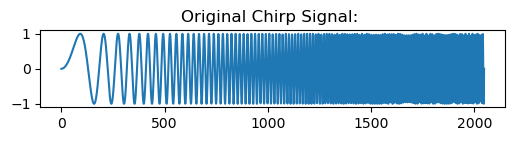

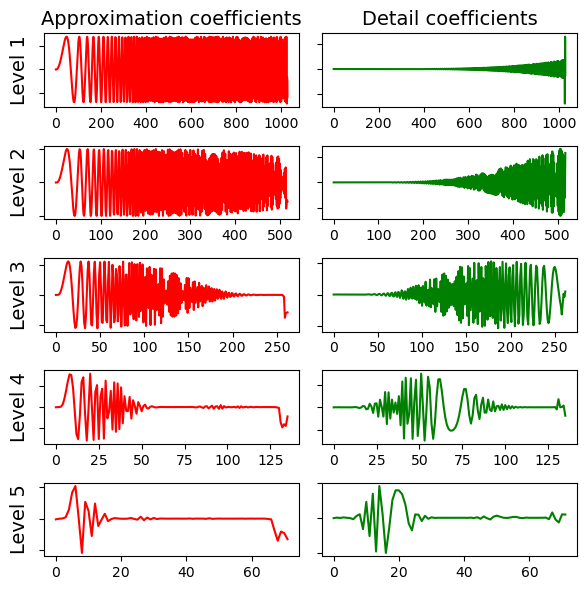

In [9]:
# Source: https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(250 * np.pi * x**2)
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

#### Example: FHR and UC

`pywt.dwt()` (used above) performs single-level DWT, and was used by the source in helping illustrate how DWT.

Below, we use `pywt.wavedec()`, which is the function for multi-level 1D DWT, where the level provided is the decomposition level (which must be 1+ - here, we set to 5).

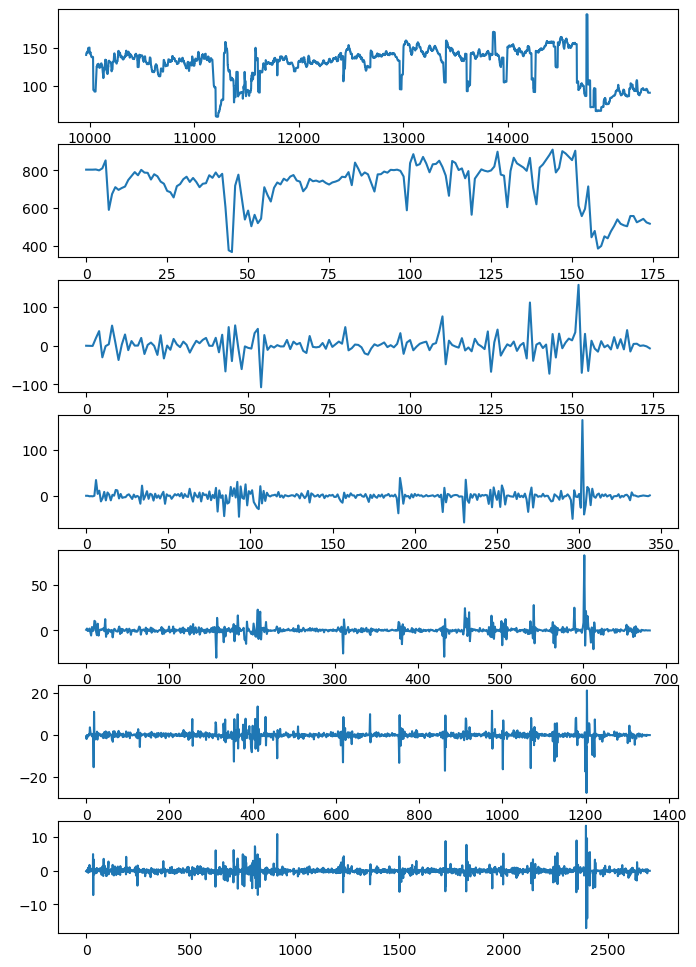

In [10]:
# Decompose fhr using db wavelet down to 5 levels
wavelets = pywt.wavedec(fhr, 'db4', level=5)

# Plot the original signal
fig, ax = plt.subplots(nrows=len(wavelets)+1, figsize=(8, 12))
ax[0].plot(fhr)

# Plot the output from DWT
for i, wavelet in enumerate(wavelets):
   ax[i+1].plot(wavelet)

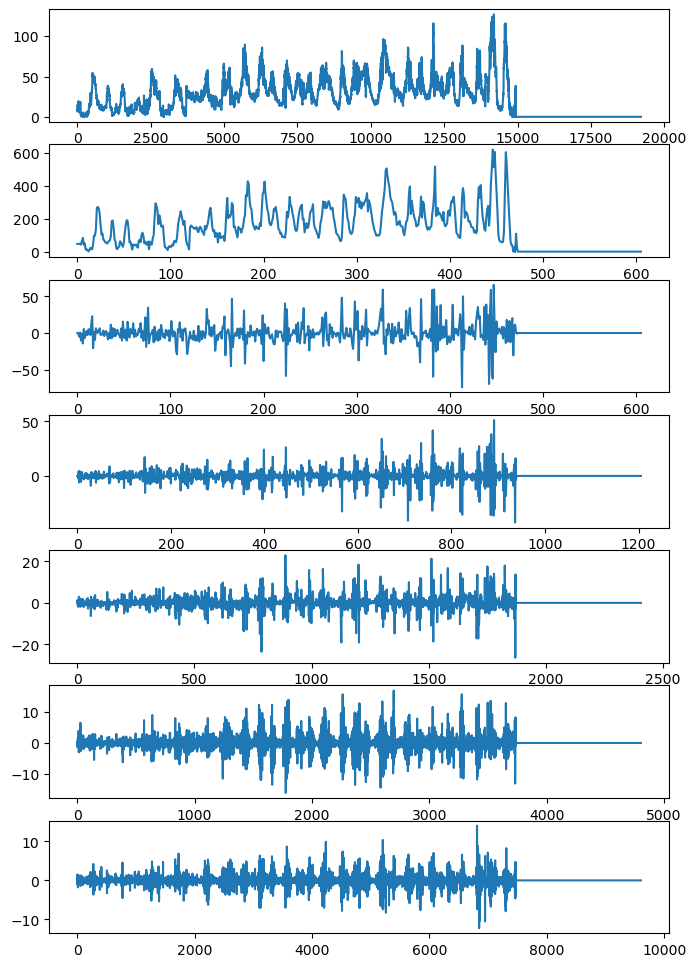

In [11]:
# Decompose uc using db wavelet down to 5 levels
wavelets = pywt.wavedec(uc, 'db4', level=5)

# Plot the original signal
fig, ax = plt.subplots(nrows=len(wavelets)+1, figsize=(8, 12))
ax[0].plot(uc)

# Plot the output from DWT
for i, wavelet in enumerate(wavelets):
   ax[i+1].plot(wavelet)

## Signal Transformation Technique #3 - Continuous Wavelet Transformation (CWT) <a class="anchor" id="cwt"></a>

CWT produces a **scaleogram**, which is a continuous time-frequency representation of the signal.

Types of wavelet that are primarily associated with CWT:
* Morlet wavelet
* Mexican hat or Ricker wavelet
* Gabor wavelets
* Complex morlet wavelet
* Meyer wavelet

# Old notes

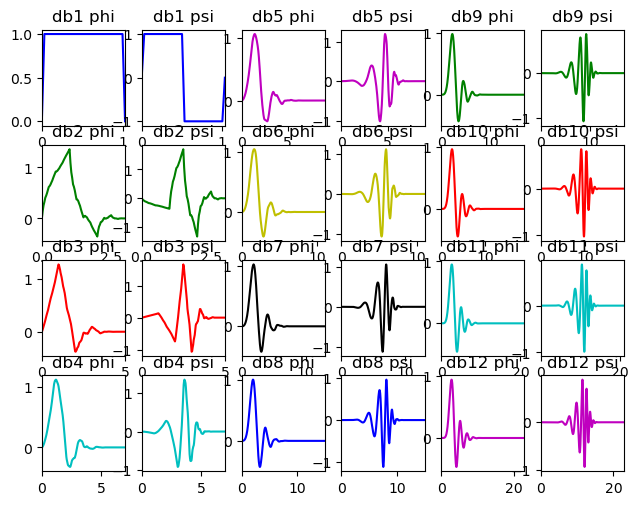

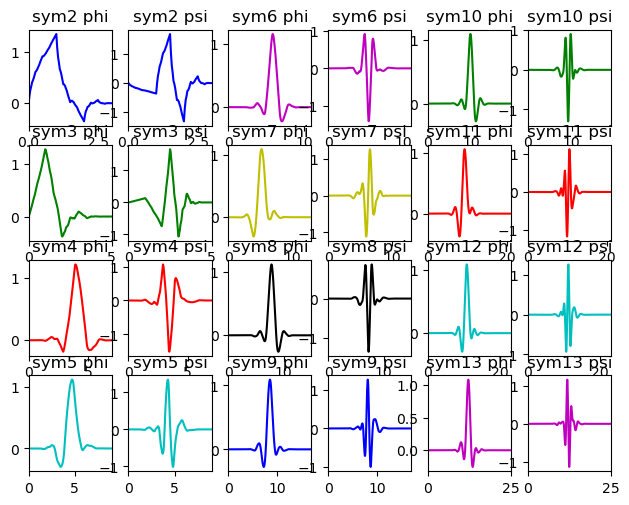

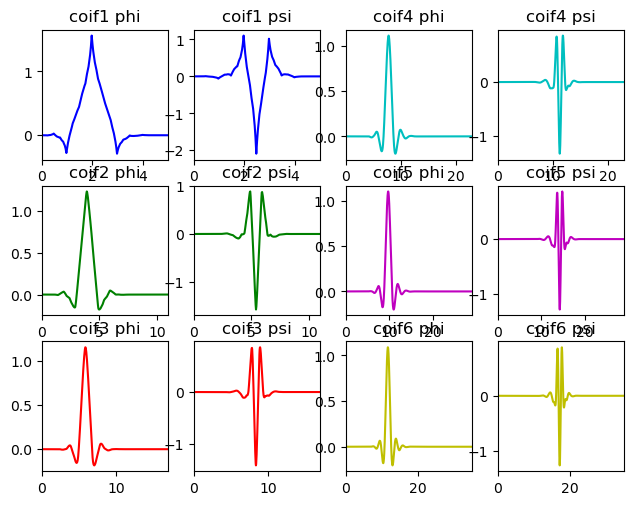

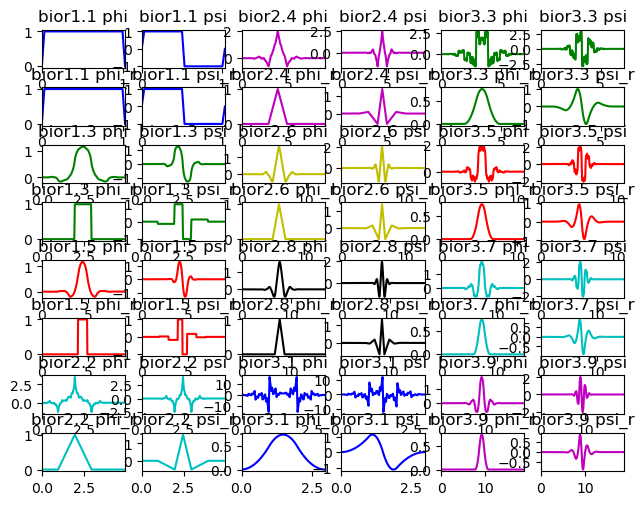

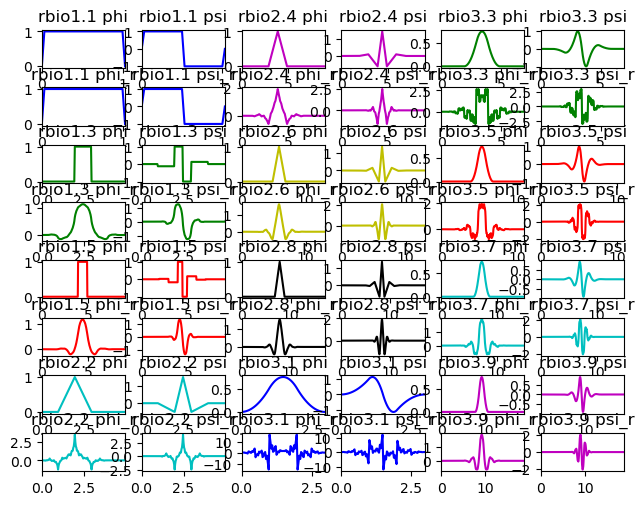

In [12]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Plot scaling and wavelet functions for db, sym, coif, bior and rbio families

import itertools

import matplotlib.pyplot as plt

import pywt


plot_data = [('db', (4, 3)),
             ('sym', (4, 3)),
             ('coif', (3, 2))]


for family, (rows, cols) in plot_data:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)
    colors = itertools.cycle('bgrcmyk')

    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, x = wavelet.wavefun(level=5)

            color = next(colors)
            ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)

    colors = itertools.cycle('bgrcmyk')
    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
            row *= 2

            color = next(colors)
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

            row += 1
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi_r")
            ax.plot(x, phi_r, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi_r")
            ax.plot(x, psi_r, color)
            ax.set_xlim(min(x), max(x))

plt.show()

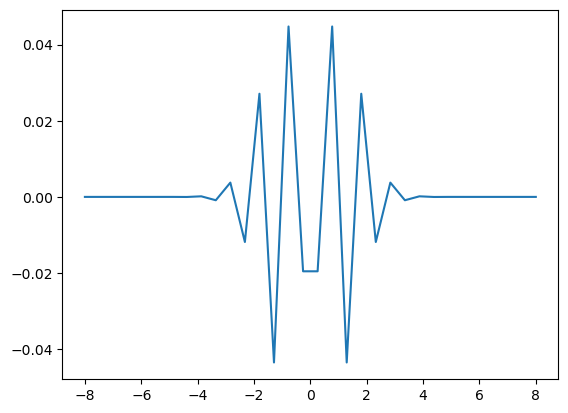

In [13]:
W = pywt.ContinuousWavelet('cmor2-1')
[psi,x] = W.wavefun(level=5)

# Plot
plt.plot(x,psi)
plt.show()

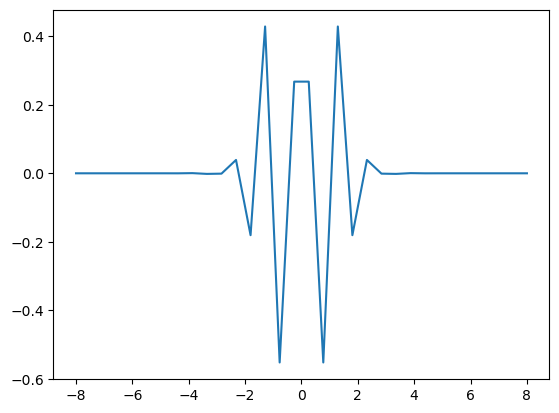

In [14]:
wavelet = pywt.ContinuousWavelet('morl')
[psi,x] = wavelet.wavefun(level=5)

# Plot
plt.plot(x,psi)
plt.show()

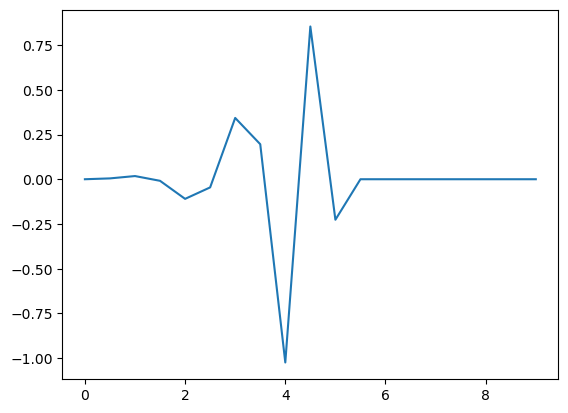

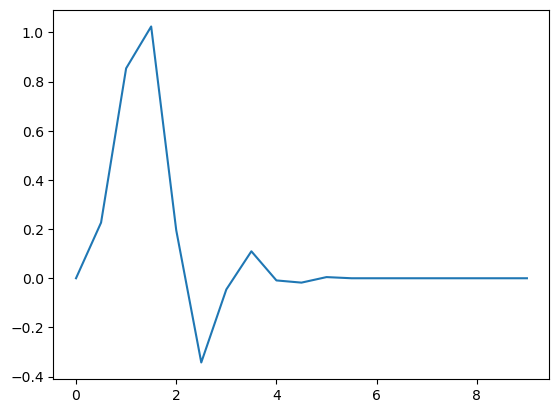

In [15]:
# Get the approximation wavelet and scaling functions for db5 and level=1
wavelet = pywt.Wavelet('db5')
[phi, psi, x] = wavelet.wavefun(level=1)

# Plot the wavelet function
plt.plot(x, psi)
plt.show()

# Plot the scaling function
plt.plot(x, phi)
plt.show()

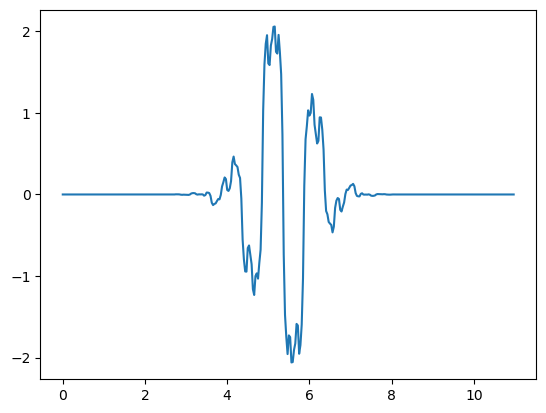

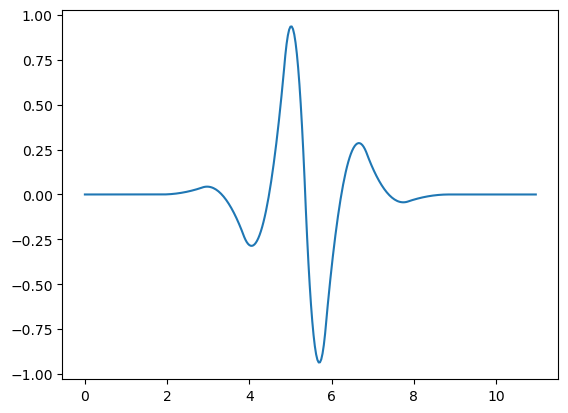

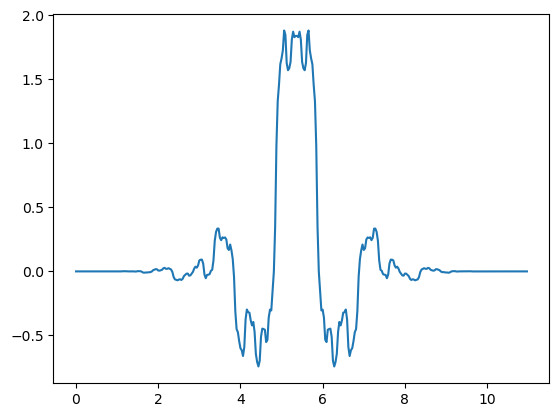

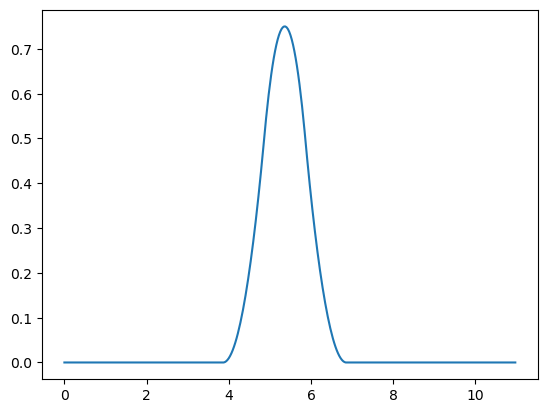

In [16]:
# For other (biorthogonal but not orthogonal) wavelets, it returns
# approximations of scaling function and wavelet function both for decomposition
# and reconstruction and corresponding x-grid coordinates.
# For example, let’s see wavelet ‘bior3.5’ and level=5.
biwavelet = pywt.Wavelet('bior3.5')
[phi_d,psi_d,phi_r,psi_r,x] = biwavelet.wavefun(level=5)

# Wavelet Function of decomposition
plt.plot(x,psi_d)
plt.show()

# wavelet function of reconstruction
plt.plot(x,psi_r)
plt.show()

# scaling functions of decomposition
plt.plot(x,phi_d)
plt.show()

# Scaling function of reconstruction
plt.plot(x,phi_r)
plt.show()

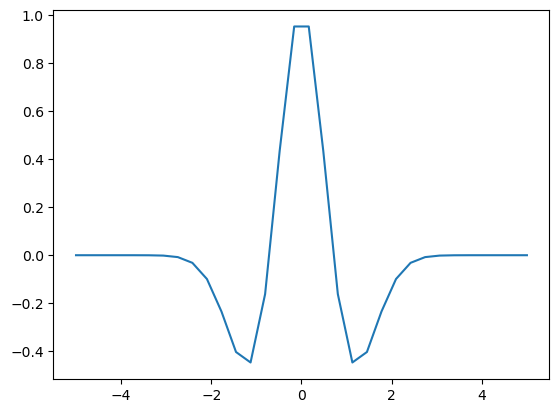

In [17]:
# Continuous wavelet function - example gaus2 level5 

# Approximation function
W = pywt.ContinuousWavelet('gaus2')
[psi,x] = W.wavefun(level=5)

# Plot
plt.plot(x,psi)
plt.show()

#### Scaling and frequency

You can stretch the wavelet, which is called **scaling it**.

**A larger scale factors leads to a lower frequency** and vice versa, as scale is inversely proportional to frequency. If you **scale** a wavelet by 2, this will **reduce the frequency by half** (also know as by an octave - an octave is interval where frequency at one point is twice frequency of other point).

To calculate the change in frequency when scaling a wavelet, you can do: pseudo-frequency = centre frequency / scaling factor. For example, 5Hz / 0.5 = 10Hz (higher frequency), or 5Hz / 2 = 2.5Hz (lower frequency). The centre frequency of the wavelet describes its general behaviour, determined by approximating the wavelet to a sine wave and taking its frequency. A sine wave is the most basic repetitive electronic waveform - just has a single fundamental frequency and no harmonics (distortions).

The standard form of the wave is the **mother wavelet**, and scaled versions are the **daughter wavelets**.

<mark>This is wrong - the wave just be getting wider at higher scales? Think am misunderstanding the input parameters</mark>

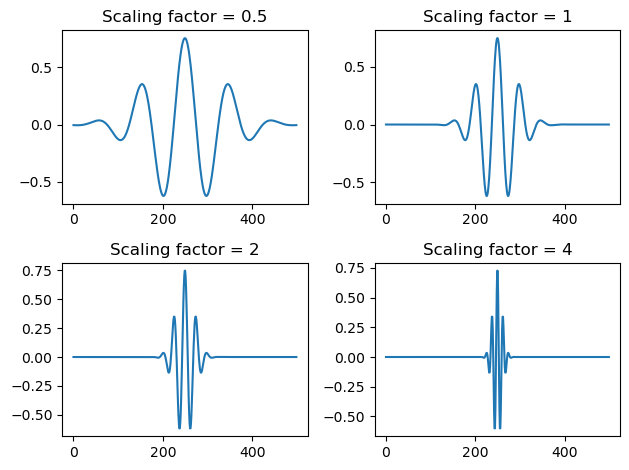

In [18]:
# Source: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html

# Define the sampling rate/frequency, fundamental frequency, and number of
# cycles per frequency (or omega), and the scale factor
fs = 500
freq = 5
n_cycles = 5

# Calculate wavelet length (e.g. 5 * (500/5) = 500)
wavelet_len = int(n_cycles * fs / freq)

# Plot the real part of the wavelet
_, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].plot(np.real(signal.morlet(M=wavelet_len, w=n_cycles, s=0.5)))
ax[0,0].title.set_text('Scaling factor = 0.5')
ax[0,1].plot(np.real(signal.morlet(M=wavelet_len, w=n_cycles, s=1)))
ax[0,1].title.set_text('Scaling factor = 1')
ax[1,0].plot(np.real(signal.morlet(M=wavelet_len, w=n_cycles, s=2)))
ax[1,0].title.set_text('Scaling factor = 2')
ax[1,1].plot(np.real(signal.morlet(M=wavelet_len, w=n_cycles, s=4)))
ax[1,1].title.set_text('Scaling factor = 4')
plt.tight_layout()

In [19]:
pywt.scale2frequency('morl', 1)

0.8125

There are different **wavelet families** with some examples below.


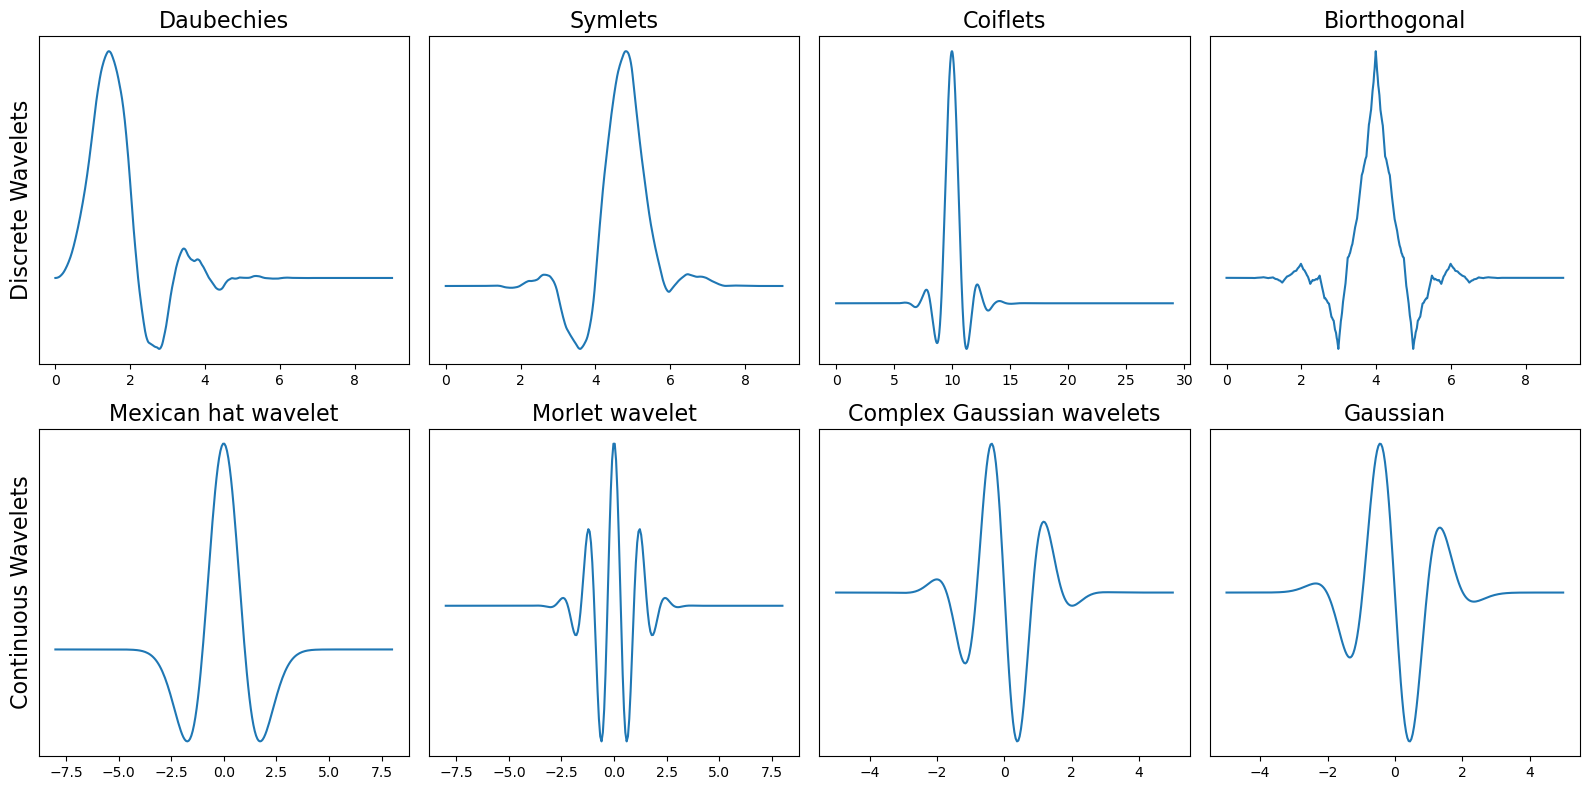

In [20]:
# Source: https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
 
plt.tight_layout()
plt.show()

In [21]:
for family in pywt.families():
    print("%s family: " % family + ', '.join(pywt.wavelist(family)))

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

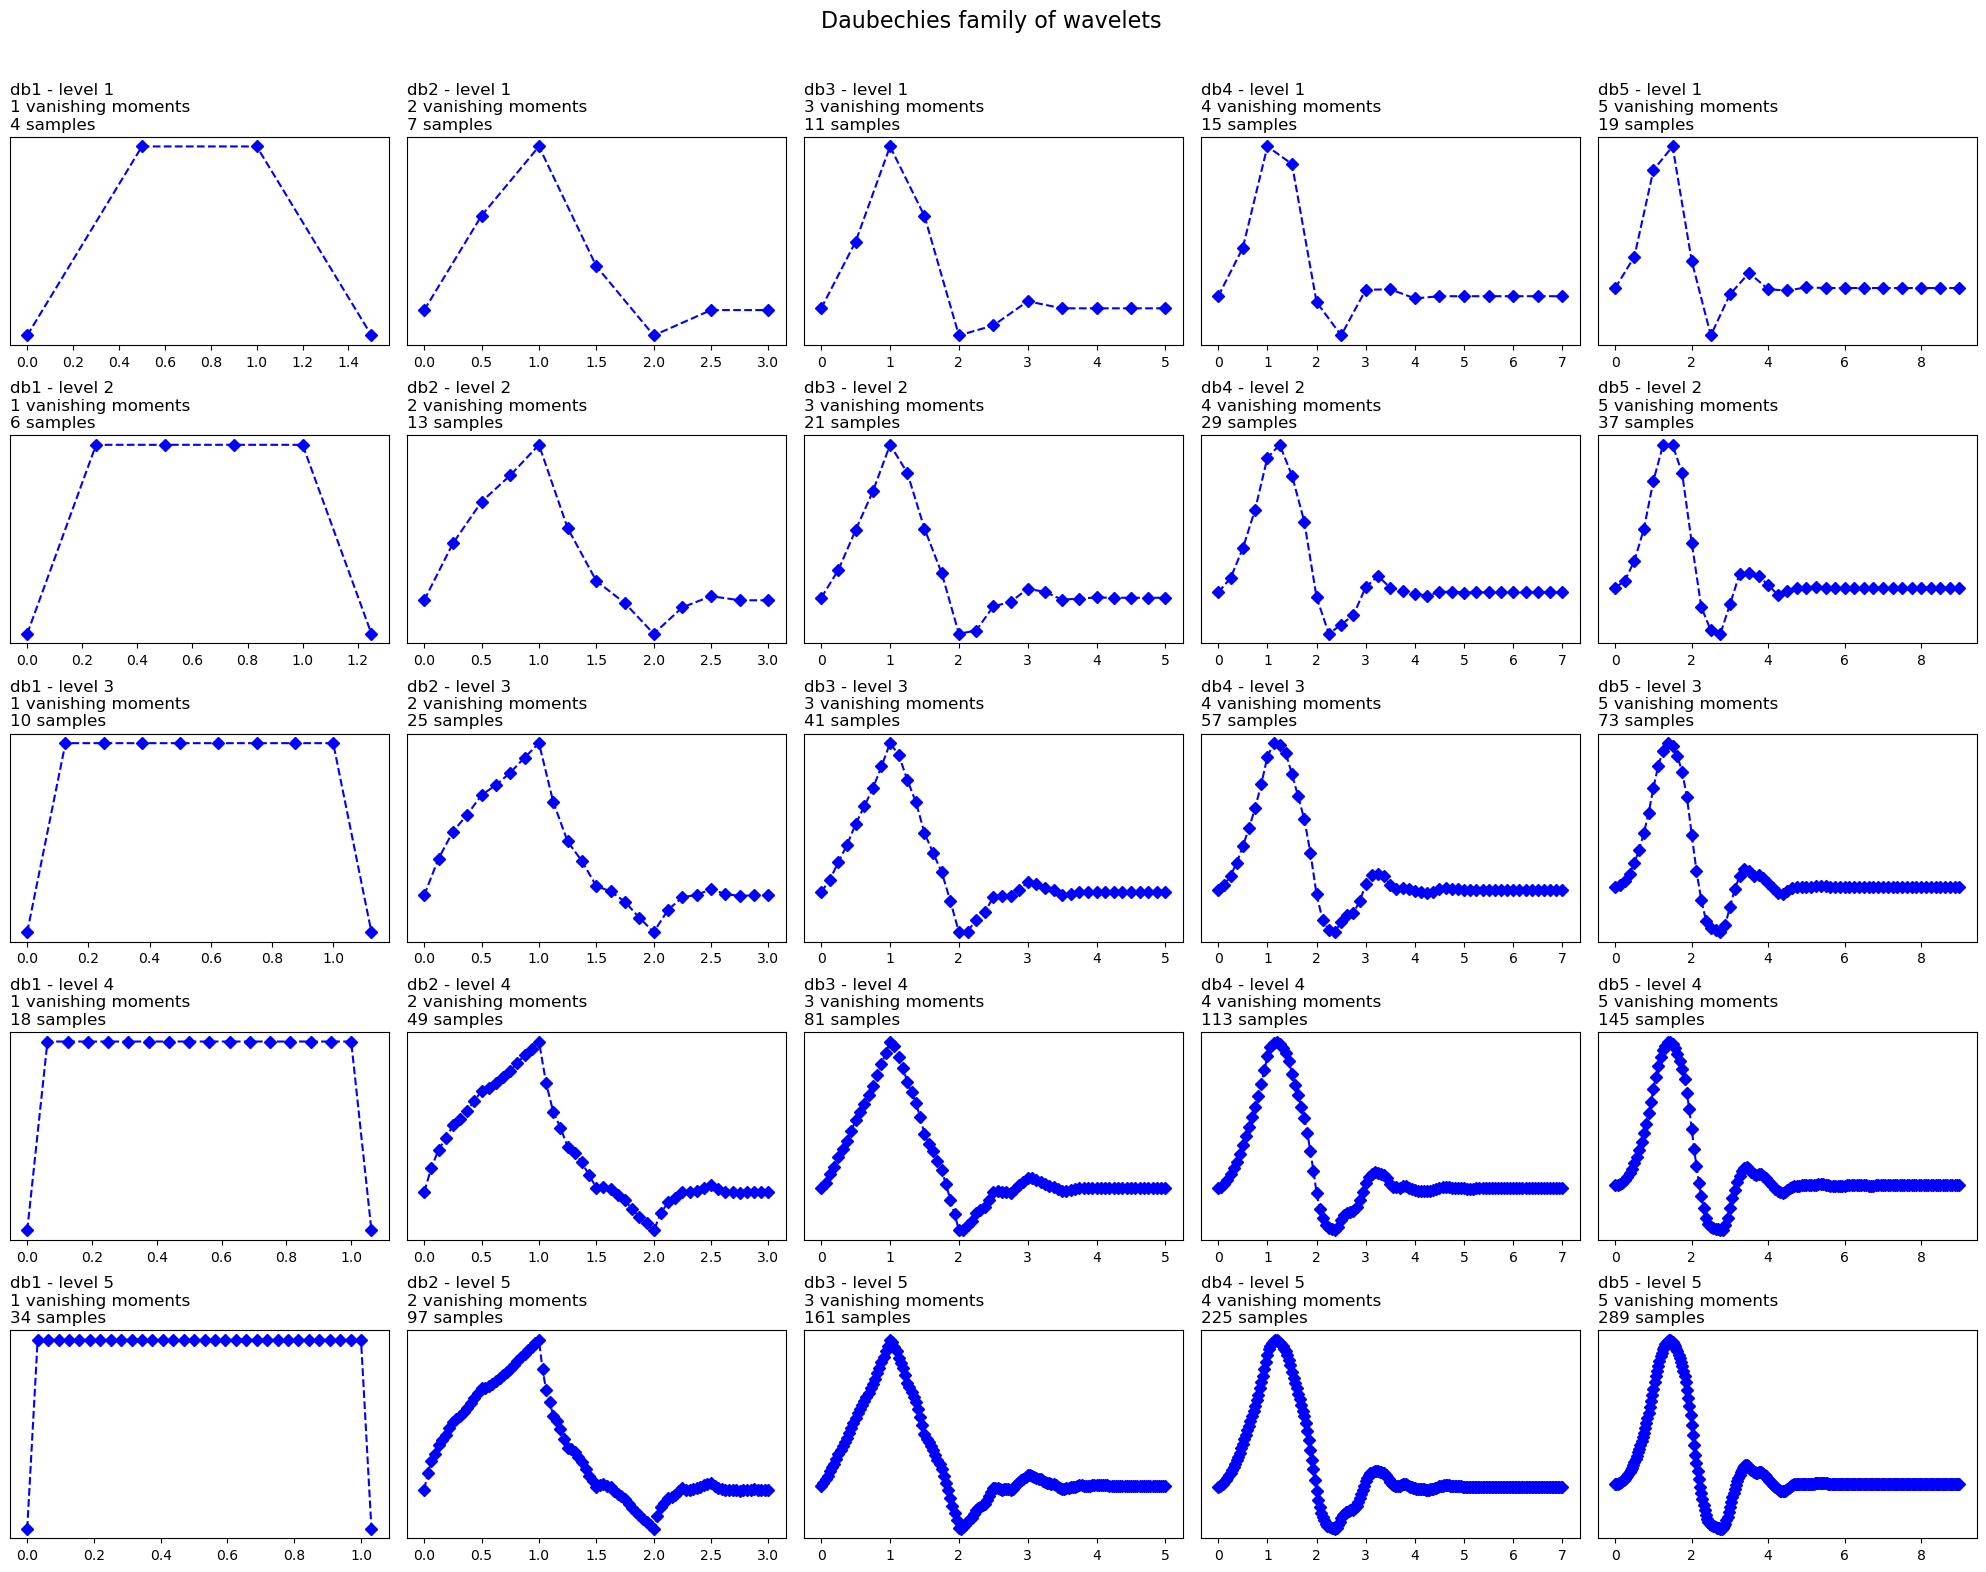

In [22]:
db_wavelets = pywt.wavelist('db')[:5]

fig, axarr = plt.subplots(ncols=5, nrows=5, figsize=(20,16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, waveletname in enumerate(db_wavelets):
    wavelet = pywt.Wavelet(waveletname)
    no_moments = wavelet.vanishing_moments_psi
    family_name = wavelet.family_name
    for row_no, level in enumerate(range(1,6)):
        wavelet_function, scaling_function, x_values = wavelet.wavefun(level = level)
        axarr[row_no, col_no].set_title("{} - level {}\n{} vanishing moments\n{} samples".format(
            waveletname, level, no_moments, len(x_values)), loc='left')
        axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Morlet Wavelets

In [23]:
print(pywt.ContinuousWavelet('morl'))

ContinuousWavelet morl
  Family name:    Morlet wavelet
  Short name:     morl
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


Morlet wavelet is a complex wavelet - it has real and imaginary dimensions as it incorporates complex numbers (numbers with real and imaginary parts).

**Real number** = includes negative and positive: integers, decimals and fractional numbers

**Imaginary number** = square root of negative number (as you can't - all numbers squared become positive) - can think of as $\sqrt{-1}$ multiplied by a real number with examples like:
* $\sqrt{-1}$ (i.e. i) * $\sqrt{4}$ (i.e. 2) = 2i
* $\sqrt{-1}$ (i.e. i) * $\sqrt{3}$ (can't simplify) = i $\sqrt{3}$

**Complex number** = sum of real number and imaginary number

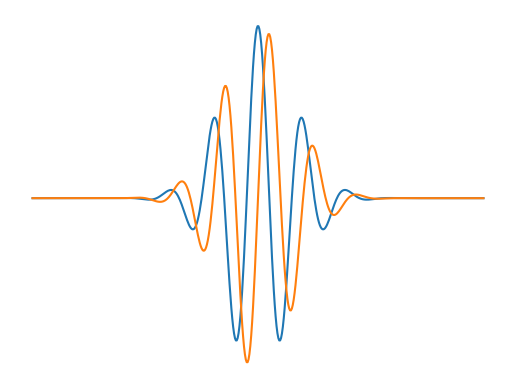

In [24]:
# Source: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html
# Plot both real and imaginary dimensions of the wavelet
_, ax = plt.subplots()
ax.plot(np.real(signal.morlet(M=wavelet_len, w=n_cycles, s=1)))
ax.plot(np.imag(signal.morlet(M=wavelet_len, w=n_cycles, s=1)))
ax.set_axis_off()